In [110]:
import sys
sys.path.append('../../')

from functools import partial
from aml_project import utils
from aml_project.models import BaseModule
from aml_project import trainer
import biosppy.signals.ecg as ecg
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm



import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.multiclass import OneVsRestClassifier
import pywt
import cv2
import neurokit2 as nk

In [2]:
#X_train, X_test, y_train = utils.load_df('data', 0)

In [3]:
%%time
X = pd.read_csv('data/X_train.csv')

CPU times: user 35.3 s, sys: 1.17 s, total: 36.5 s
Wall time: 36.8 s


In [4]:
%%time
X_test = pd.read_csv('data/X_test.csv')

CPU times: user 23.3 s, sys: 387 ms, total: 23.7 s
Wall time: 23.8 s


In [99]:
%%time
y = pd.read_csv('data/y_train.csv')

CPU times: user 4.26 ms, sys: 10.7 ms, total: 15 ms
Wall time: 24.8 ms


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y.y)

In [7]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, type(y_train), type(y_val)

((3837, 8652),
 (1280, 8652),
 (3837, 2),
 (1280, 2),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [197]:
def load_data(source_x, source_y=None, sampling_rate=150, wavelet='mexh', thresh=0.2, dims=(100, 100), train=True, n_samples=0):
    before, after = 90, 110
    groups= []
    if type(source_x) == str:
        df_x = pd.read_csv(source_x)
    else:
        df_x = source_x

    if n_samples > 0:
            df_x = df_x.iloc[:n_samples]
        
    scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, dims[0] + 1, 1)
    
    if train:
        if type(source_y) == str:
            arr_y = pd.read_csv(source_y).y.values
        else:
            arr_y = source_y.y.values

    x_cwt_train, x_rr_train, y_train = [], [], []
    for j in tqdm(range(len(df_x))):
        signal = df_x.iloc[j].dropna()    
        coefs, freq = pywt.cwt(signal, scales, wavelet, 1.0 / sampling_rate)
        rpeaks = ecg.engzee_segmenter(signal, sampling_rate, threshold=thresh)['rpeaks']
        
        avg_rri = np.mean(np.diff(rpeaks))
        
        x_cwt, x_rr, y = [], [], []
        for i in range(len(rpeaks)):
            if i == 0 or i == len(rpeaks) - 1:
                continue
                
            
            
            x_cwt.append(
                cv2.resize(coefs[:, max(rpeaks[i] - before, 0):min(rpeaks[i] + after, coefs.shape[1])], dims)
            )
            x_rr.append([
                rpeaks[i] - rpeaks[i - 1] - avg_rri,  # previous RR Interval
                rpeaks[i + 1] - rpeaks[i] - avg_rri,  # post RR Interval
                (rpeaks[i] - rpeaks[i - 1]) / (rpeaks[i + 1] - rpeaks[i]),  # ratio RR Interval
                np.mean(np.diff(rpeaks[np.maximum(i - 10, 0):i + 1])) - avg_rri  # local RR Interval
            ])
            
            if train:
                y.append(arr_y[j])
                
            groups.append(j)
        
        x_cwt_train.append(x_cwt)
        x_rr_train.append(x_rr)
        
        if train:
            y_train.append(y)
    
    x_cwt_train = np.expand_dims(np.concatenate(x_cwt_train, axis=0), axis=1).astype(np.float32)
    x_rr_train = np.concatenate(x_rr_train, axis=0).astype(np.float32)
    x_rr_train = RobustScaler().fit_transform(x_rr_train)
    
    if train:
        y_train = np.concatenate(y_train, axis=0).astype(np.int64)
        return x_cwt_train, x_rr_train, y_train, np.array(groups).astype(np.int64)
    
    return x_cwt_train, x_rr_train, np.array(groups).astype(np.int64)

In [98]:
%%time
x_cwt, x_rr, y_segmented, groups = load_data(X, y, n_samples=0, dims=(100, 100))

AttributeError: 'numpy.ndarray' object has no attribute 'y'

In [77]:
idx_group = np.where(groups == 0)[0]
np.median(x_cwt[idx_group], axis=0).shape

(1, 100, 100)

In [87]:
# Aggregate features
def aggregate_features(x_cwt, x_rr, groups):
    features_cwt = []
    features_rr = []
    
    for g in tqdm(np.unique(groups)):
        idx_group = np.where(groups == g)[0]
        
        x_cwt_mean = np.mean(x_cwt[idx_group], axis=0)
        x_cwt_med = np.median(x_cwt[idx_group], axis=0)
        x_cwt_std = np.std(x_cwt[idx_group], axis=0)
        x_cwt_min = np.min(x_cwt[idx_group], axis=0)
        x_cwt_max = np.max(x_cwt[idx_group], axis=0)
    
        x_rr_mean = np.mean(x_rr[idx_group], axis=0)
        x_rr_med = np.median(x_rr[idx_group], axis=0)
        x_rr_std = np.std(x_rr[idx_group], axis=0)
        x_rr_min = np.min(x_rr[idx_group], axis=0)
        x_rr_max = np.max(x_rr[idx_group], axis=0)
        
        
    
        agg_cwt = np.concatenate([
            x_cwt_mean,
            x_cwt_med,
            x_cwt_std,
            x_cwt_min,
            x_cwt_max
        ])
        
        agg_rr = np.concatenate([
            x_rr_mean,
            x_rr_med,
            x_rr_std,
            x_rr_min,
            x_rr_max,
        ])
        
        features_cwt.append(agg_cwt)
        features_rr.append(agg_rr)
    
    return np.stack(features_cwt), np.stack(features_rr)

In [ ]:
np.mean()

In [39]:
np.concatenate([x_features_cwt[0], x_features_cwt[1]]).shape

(2, 100, 100)

In [91]:
%%time
x_features_cwt, x_features_rr = aggregate_features(x_cwt, x_rr, groups)

100%|██████████| 5117/5117 [00:47<00:00, 107.02it/s]


CPU times: user 33.2 s, sys: 5.6 s, total: 38.8 s
Wall time: 49.2 s


In [100]:
x_cwt.shape, x_features_cwt.shape

((201251, 1, 100, 100), (5117, 5, 100, 100))

In [101]:
x_rr.shape, x_features_rr.shape

((201251, 4), (5117, 20))

In [97]:
y.shape

(201251,)

In [7]:
%%time
x_cwt_train, x_rr_train, y_train, groups_train = load_data(X_train, y_train, n_samples=0, dims=(100, 100))

NameError: name 'X_train' is not defined

In [8]:
%%time
x_cwt_val, x_rr_val, y_val, groups_val = load_data(X_val, y_val, n_samples=0, dims=(100, 100))

NameError: name 'X_val' is not defined

In [9]:
%%time
x_cwt_test, x_rr_test, groups_test = load_data(X_test, train=False, n_samples=0, dims=(100, 100))

CPU times: user 4min 32s, sys: 8.29 s, total: 4min 41s
Wall time: 4min 43s


In [10]:
def plot_signal(data, idx, vlines=[], titles=[]):
    
    if type(idx) == int:
        idx = range(idx)
        
    width = 20
    ncols = 1
    if len(data.shape) > 2:
        ncols = 5
        width = 2
        
    nrows = len(idx) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*width, nrows*5))
    if len(idx) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(data.shape) > 2:
            ax.imshow(data[i][0])
        else:
            measurements = data.iloc[i].dropna().to_numpy(dtype='float32')
            #measurements = measurements[0:-1:10]
            measurements /= 1000
            seconds = np.arange(0, len(measurements)) / 30
            ax.plot(seconds, measurements)
            for line in vlines:
                ax.axvline(x=(line/30))
        if len(titles) > 0:
            ax.set_title(titles[idx[i]])

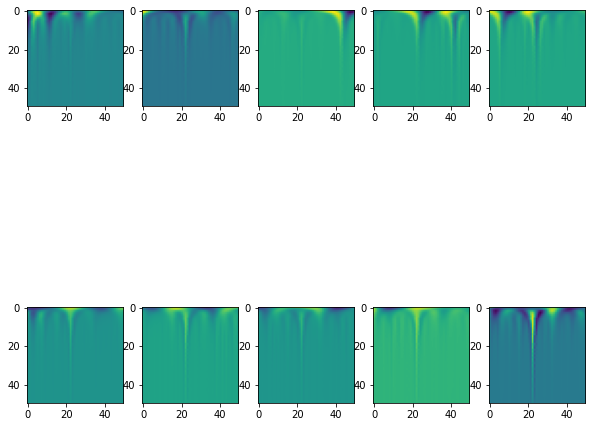

In [11]:
plot_signal(x_cwt_train, 10)

In [106]:
class MyModule(nn.Module):
    def __init__(self, n_classes=4):
        super(MyModule, self).__init__()
        self.conv1 = nn.Conv2d(5, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(84, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        x = torch.cat((x1, x2), dim=1)  # (68,)
        x = F.relu(self.fc1(x))  # (32,)
        x = self.fc2(x)  # (4,)
        return x

In [189]:
class MyModule2(MyModule):

    def forward(self, x1):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        return x1

In [150]:
callbacks = [
    Initializer("[conv|fc]*.weight", fn=torch.nn.init.kaiming_normal_),
    Initializer("[conv|fc]*.bias", fn=partial(torch.nn.init.constant_, val=0.0)),
    LRScheduler(policy=StepLR, step_size=5, gamma=0.1),
    EpochScoring(scoring=make_scorer(f1_score, average="micro"), lower_is_better=False, name="valid_f1"),
    #TensorBoard(SummaryWriter(log_dir))
]

In [113]:
y_class = y.y.values
class_weight = compute_class_weight('balanced', classes=np.unique(y_class), y=y_class)
class_weight = torch.Tensor(class_weight)
class_weight

tensor([0.4222, 2.8877, 0.8679, 7.5250])

In [151]:
clf = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=4),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=15,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
    criterion__weight=class_weight
)

In [104]:
y.y.values

array([0, 0, 0, ..., 0, 0, 2])

In [152]:
%%time
clf.fit({'x1': x_features_cwt, 'x2': x_features_rr}, y_class)

  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        3.4825       0.4014      0.4014        6.1644  0.0100  39.8710
      2        1.4750       0.3662      0.3662        4.4902  0.0100  36.5767
      3        1.1551       0.5039      0.5039        2.1769  0.0100  36.5006
      4        1.0193       0.5654      0.5654        1.0974  0.0100  36.3850
      5        0.9398       0.6104      0.6104        1.0444  0.0100  36.4398
      6        0.9200       0.6123      0.6123        0.9866  0.0010  36.6941
      7        0.9097       0.6143      0.6143        0.9660  0.0010  36.5619
      8        0.9006       0.6250      0.6250        0.9558  0.0010  36.4815
      9        0.8938       0.6250      0.6250        0.9489  0.0010  36.4075
     10        0.8874       0.6250      0.6250        0.9451  0.0010  36.5718
     11        0.8834       0.6260      0.6260        0.9448  0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (conv1): Conv2d(5, 16, kernel_size=(7, 7), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (pooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pooling3): AdaptiveMaxPool2d(output_size=(1, 1))
    (fc1): Linear(in_features=84, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=4, bias=True)
  ),
)

In [156]:
# Save clf
import pickle
with open('cwt_cnn.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [160]:
clf.module.children()[-1]

TypeError: 'generator' object is not subscriptable

In [193]:
feature_net = MyModule2()
feature_net.children = clf.module.children()

In [195]:
%%time
features_train = feature_net(torch.Tensor(x_features_cwt))

CPU times: user 22.4 s, sys: 9.83 s, total: 32.2 s
Wall time: 25.7 s


In [198]:
%%time
x_cwt_test, x_rr_test, groups_test = load_data(X_test, train=False, n_samples=0, dims=(100, 100))

100%|██████████| 3411/3411 [06:44<00:00,  8.42it/s]


CPU times: user 6min 16s, sys: 37 s, total: 6min 53s
Wall time: 8min 32s


In [199]:
%%time
x_features_cwt_test, x_features_rr = aggregate_features(x_cwt_test, x_rr_test, groups_test)

100%|██████████| 3411/3411 [00:27<00:00, 124.38it/s]


CPU times: user 22.2 s, sys: 2.72 s, total: 24.9 s
Wall time: 27.6 s


In [200]:
%%time
features_test = feature_net(torch.Tensor(x_features_cwt_test))

CPU times: user 14.8 s, sys: 6.22 s, total: 21 s
Wall time: 17.5 s


In [219]:
pd.DataFrame(np.array(features_train.detach())).shape

(5117, 64)

In [215]:
pd.DataFrame(np.array(features_train.detach())).to_csv('data/features_train.csv')
pd.DataFrame(np.array(features_train.detach())).to_csv('data/features_test.csv')

In [202]:
features_train.shape, features_test.shape

(torch.Size([5117, 64]), torch.Size([3411, 64]))

In [217]:
df_test = pd.read_csv('data/features_train.csv')
df_test.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,0,1.053884,0.527662,1.003648,0.649300,1.065991,1.139568,0.577173,0.869370,0.646057,...,1.025725,1.056092,0.651778,0.985535,0.792129,0.829983,0.293246,1.006424,0.694418,0.228594
1,1,0.667098,0.397549,0.671067,0.693171,0.637909,0.552870,0.435969,0.425254,0.628000,...,0.000000,0.022356,0.682516,0.588095,0.571876,0.282250,0.346580,0.242213,0.696862,0.000000
2,2,2.496626,1.050576,1.038037,0.664625,1.444397,1.544839,2.184130,1.021845,0.631937,...,2.031850,0.614756,0.558040,1.211306,1.081941,1.337465,1.207210,2.611131,0.672480,1.290483
3,3,3.124188,0.661929,1.022232,0.595916,2.845088,1.314521,2.129592,0.593108,0.658319,...,2.258999,0.590005,0.556291,1.628519,0.631148,2.043719,0.975908,2.160063,0.690835,2.499965
4,4,1.736731,1.023247,0.727325,0.669825,1.163596,1.093796,1.248574,0.996106,0.644623,...,0.742766,0.000000,0.620245,0.910507,0.500981,1.127332,0.509404,1.279899,0.685811,1.425536
5,5,1.105614,0.527920,0.799911,0.898149,0.835801,0.383975,0.365174,1.375301,1.273502,...,0.000000,0.500843,0.761378,0.441834,0.490314,0.447509,0.223884,0.766456,0.683172,0.273357
6,6,2.476705,1.283704,1.198632,0.615576,1.449704,2.024672,1.704568,0.932451,0.678186,...,2.066629,0.454198,0.568291,0.922337,0.877432,1.549912,1.212893,2.627507,0.706777,1.677669
7,7,2.904392,1.039677,1.429466,0.608672,2.027883,1.678837,1.536985,0.687359,0.631743,...,1.972809,0.158918,0.556390,1.000433,0.661309,1.904604,0.977114,2.013922,0.685082,2.252279
8,8,2.270781,0.238646,1.043478,0.618117,2.391544,0.622831,0.709428,1.205754,0.555951,...,1.560009,1.322023,0.727949,0.494784,1.314536,0.537894,0.167302,3.345844,0.565081,2.280358
9,9,0.659825,0.646650,0.537403,0.770553,0.367418,0.347055,0.404829,1.635380,0.848491,...,0.830005,1.196949,0.700206,0.875473,0.632929,1.092206,0.215831,0.451516,0.695448,0.000000


In [214]:
df_test.values.shape

(5117, 65)

# Trash from here
or not?
no guarantees

In [14]:
class SpecificVsRestClassifier(TransformerMixin):
    def __init__(self, clf, one_class):
        self.clf = copy.deepcopy(clf)
        self.one_class = one_class
    
    def split_one_vs_rest(self, y):
        idx_one = np.where(y == self.one_class)[0]
        idx_rest = np.where(y != self.one_class)[0]
        return idx_one, idx_rest
    
    def fit(self, X, y):
        idx_one, idx_rest = self.split_one_vs_rest(y)
        y_one_vs_rest = np.zeros_like(y)
        y_one_vs_rest[idx_one] = 1
        
        # Balance class weights
        if type(self.clf) == skorch.classifier.NeuralNetClassifier:
            n_samples = len(y_one_vs_rest)
            print(n_samples, len(idx_rest), len(idx_one))
            class_weight = n_samples / torch.tensor([len(idx_rest), len(idx_one)])
            self.clf.estimator__weight = class_weight
            print(f'set class weight to: {class_weight}')
        else:
            self.clf.class_weigth = 'balanced'
        self.clf.fit(X, y_one_vs_rest)
        return self
    
    def transform(self, X, y=None):
        return self.clf.predict(X)

In [15]:
# Noise vs rest
noise_vs_rest_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [16]:
noise_vs_rest_clf = SpecificVsRestClassifier(noise_vs_rest_net, 3)
noise_vs_rest_clf.fit({'x1': x_cwt_train, 'x2': x_rr_train}, y_train)

134597 130108 4489
set class weight to: tensor([ 1.0345, 29.9837])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.1612       0.9687      0.5993        0.0991  0.0100  63.0540
      2        0.1032       0.9690      0.6237        0.0930  0.0100  61.2749
      3        0.0975       0.9691      0.6161        0.0907  0.0100  61.3022
      4        0.0940       0.9696      0.6269        0.0895  0.0100  61.3065
      5        0.0913       0.9695      0.6436        0.0889  0.0100  61.1121
      6        0.0826       0.9708      0.6391        0.0862  0.0010  61.2732
      7        0.0800       0.9715      0.6560        0.0856  0.0010  61.0439
      8        0.0791       0.9716      0.6617        0.0853  0.0010  61.0808
      9        0.0783       0.9714      0.6638        0.0849  0.0010  61.1748
     10        0.0776       0.9716      0.6694        0.0846  0.0010  61.37

In [17]:
# Healthy vs sick
healthy_vs_sick_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [18]:
idx_noise, idx_rest = noise_vs_rest_clf.split_one_vs_rest(y_train)

x_cwt_train_rest = x_cwt_train[idx_rest]
x_rr_train_rest = x_rr_train[idx_rest]
y_train_rest = y_train[idx_rest]

healthy_vs_sick_clf = SpecificVsRestClassifier(healthy_vs_sick_net, 0)
healthy_vs_sick_clf.fit({'x1': x_cwt_train_rest, 'x2': x_rr_train_rest}, y_train_rest)

130108 55700 74408
set class weight to: tensor([2.3359, 1.7486])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.5924       0.7333      0.6995        0.5466  0.0100  60.1786
      2        0.5444       0.7375      0.7047        0.5483  0.0100  59.3332
      3        0.5294       0.7479      0.7227        0.5260  0.0100  58.8817
      4        0.5188       0.7499      0.7269        0.5211  0.0100  58.8047
      5        0.5105       0.7507      0.7283        0.5244  0.0100  58.7173
      6        0.4900       0.7777      0.7640        0.4840  0.0010  58.6170
      7        0.4804       0.7793      0.7662        0.4815  0.0010  58.7483
      8        0.4766       0.7794      0.7663        0.4799  0.0010  58.5952
      9        0.4735       0.7800      0.7672        0.4785  0.0010  58.7367
     10        0.4707       0.7813      0.7686        0.4773  0.0010  58.5809

In [19]:
# Sick vs sick
sick_vs_sick_net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule(n_classes=2),
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=10,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [20]:
idx_healthy, idx_sick = healthy_vs_sick_clf.split_one_vs_rest(y_train_rest)

x_cwt_train_sick = x_cwt_train[idx_sick]
x_rr_train_sick = x_rr_train[idx_sick]
y_train_sick = y_train[idx_sick]

sick_vs_sick_clf = SpecificVsRestClassifier(healthy_vs_sick_net, 1)
sick_vs_sick_clf.fit({'x1': x_cwt_train_sick, 'x2': x_rr_train_sick}, y_train_sick)

55700 49814 5886
set class weight to: tensor([1.1182, 9.4631])
  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        0.4262       0.8952      0.4881        0.3016  0.0100  25.5885
      2        0.2627       0.8958      0.5016        0.2826  0.0100  25.5187
      3        0.2438       0.9040      0.6055        0.2654  0.0100  25.4798
      4        0.2311       0.9056      0.6572        0.2570  0.0100  25.4994
      5        0.2222       0.9125      0.6708        0.2552  0.0100  25.3621
      6        0.2007       0.9151      0.6822        0.2098  0.0010  25.5619
      7        0.1930       0.9157      0.6982        0.2088  0.0010  25.5163
      8        0.1895       0.9168      0.7084        0.2077  0.0010  25.3692
      9        0.1871       0.9182      0.7159        0.2068  0.0010  25.2356
     10        0.1850       0.9200      0.7253        0.2057  0.0010  25.2800


In [34]:
s = 10
y_pred = sick_vs_sick_clf.transform({'x1': x_cwt_val[:s], 'x2': x_rr_val[:s]})

In [53]:
len(list({'x1': x_cwt_val[:10], 'x2': x_rr_val[:10]}.values())[0])

10

In [40]:
y_result = np.empty(len(X))
idx = np.where(y_pred == 0)[0]
y_result[idx] = 1

In [95]:
def predict_patients(clfs, X):
    nsamples = len(list(X.values())[0])
    y_result = - np.ones(nsamples)
    X_samples = X
    
    for clf in clfs:
        y_pred = clf.transform(X_samples)
        idx_one = np.where(y_pred == 1)[0]
        idx_rest = np.where(y_pred == 0)[0]
        
        y_result[idx_one] = clf.one_class
        
        if len(idx_rest) == 0:
            break
        
        X_samples = {'x1': X_samples['x1'][idx_rest], 'x2': X_samples['x2'][idx_rest]}
        
    
    idx_last = np.where(y_result < 0)[0]
    y_result[idx_last] = clfs[-1].one_class
    return y_result

In [102]:
clfs = [noise_vs_rest_clf, healthy_vs_sick_clf, sick_vs_sick_clf]
y_result = predict_patients(clfs, {'x1': x_cwt_val, 'x2': x_rr_val})
df_preds = pd.DataFrame({'groups': groups_val, 'preds': y_result, 'truth': y_val})
df_preds_grouped = df_preds.groupby('groups').agg(lambda x: x.value_counts().index[0])
y_preds = df_preds_grouped.preds.values
y_val_grouped = df_preds_grouped.truth.values
f1_score(y_val_grouped, y_preds, average='weighted')

0.39434616388690474

In [105]:
idx_filter = np.where(y_val != 3)[0]
X_val_filtered = {'x1': x_cwt_val[idx_filter], 'x2': x_rr_val[idx_filter]}
y_val_filtered = y_val[idx_filter]
groups_val_filtered = groups_val[idx_filter]

clfs = [healthy_vs_sick_clf, sick_vs_sick_clf]

y_result = predict_patients(clfs, X_val_filtered)
df_preds = pd.DataFrame({'groups': groups_val_filtered, 'preds': y_result, 'truth': y_val_filtered})
df_preds_grouped = df_preds.groupby('groups').agg(lambda x: x.value_counts().index[0])
y_preds = df_preds_grouped.preds.values
y_val_grouped = df_preds_grouped.truth.values
f1_score(y_val_grouped, y_preds, average='weighted')

0.5378189656813283

In [21]:
%%time
net.fit({'x1': x_cwt_train, 'x2': x_rr_train}, y_train)

  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr      dur
-------  ------------  -----------  ----------  ------------  ------  -------
      1        1.3530       0.4871      0.4246        1.1630  0.0010  64.3184
      2        1.1418       0.5365      0.4531        1.1017  0.0010  62.3102
      3        1.0772       0.5598      0.4714        1.0623  0.0010  62.1270
      4        1.0374       0.5759      0.4904        1.0371  0.0010  61.7806
      5        1.0096       0.5925      0.5026        1.0212  0.0010  61.6510
      6        0.9664       0.5836      0.4906        1.0192  0.0001  62.0657
      7        0.9461       0.5833      0.4925        1.0138  0.0001  61.7416
      8        0.9405       0.5839      0.4933        1.0108  0.0001  62.2257
      9        0.9362       0.5842      0.4943        1.0081  0.0001  61.7397
     10        0.9323       0.5851      0.4955        1.0054  0.0001  62.0358
     11        0.9242       0.5848      0.4938        1.0081  0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (pooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pooling3): AdaptiveMaxPool2d(output_size=(1, 1))
    (fc1): Linear(in_features=68, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=4, bias=True)
  ),
)

In [22]:

torch.cuda.is_available()

False

In [22]:
import pickle
with open('cwt_cnn_cleaned.pkl', 'wb') as f:
    pickle.dump(net, f)

In [43]:
x_cwt_test, x_rr_test, groups = load_data('data/X_test.csv', '', train=False)

In [44]:
x_cwt_test.shape, x_rr_test.shape, groups.shape

((123542, 1, 100, 100), (123542, 4), (123542,))

In [23]:
preds_beat = net.predict({'x1':x_cwt_val, 'x2': x_rr_val})

In [28]:
y_val.shape, y_preds.shape

((45504,), (1280,))

In [29]:
df_preds = pd.DataFrame({'groups': groups_val, 'preds': preds_beat, 'truth': y_val})
df_preds_grouped = df_preds.groupby('groups').agg(lambda x: x.value_counts().index[0])
y_preds = df_preds_grouped.preds.values
y_val_grouped = df_preds_grouped.truth.values

In [31]:
from sklearn.metrics import f1_score

f1_score(y_val_grouped, y_preds, average='weighted')

0.6766670613804765

In [65]:
miss_clf = np.where(y_preds != y_val_grouped)[0]
miss_clf

array([   1,    3,    5,    8,   18,   19,   21,   24,   29,   32,   34,
         37,   38,   39,   40,   45,   48,   59,   60,   61,   64,   65,
         68,   72,   74,   77,   78,   84,   88,   97,   99,  101,  106,
        108,  113,  115,  117,  120,  126,  135,  136,  144,  145,  146,
        149,  150,  155,  156,  157,  159,  161,  168,  171,  178,  179,
        182,  184,  186,  189,  198,  199,  201,  203,  204,  211,  212,
        216,  218,  220,  222,  223,  227,  229,  230,  232,  235,  237,
        238,  242,  247,  254,  257,  259,  264,  266,  270,  273,  276,
        278,  280,  284,  285,  286,  287,  289,  290,  291,  293,  294,
        297,  298,  299,  300,  304,  306,  308,  316,  318,  320,  321,
        325,  327,  330,  333,  337,  343,  348,  349,  351,  359,  365,
        367,  369,  372,  375,  380,  389,  393,  398,  400,  405,  406,
        407,  413,  417,  420,  426,  427,  429,  430,  431,  432,  433,
        435,  437,  443,  448,  452,  454,  455,  4